Otsu threshold = 11.0


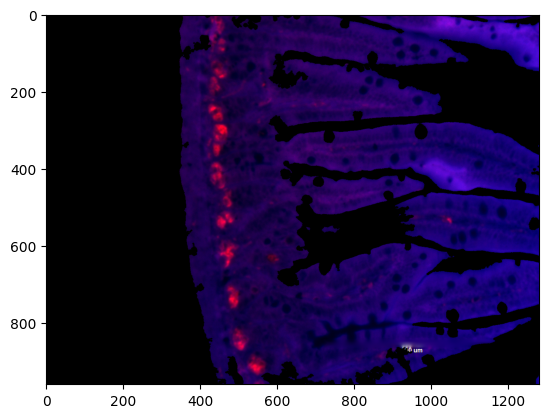

In [30]:
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy as scipy_entropy
from scipy.ndimage import binary_fill_holes

# Cell 0: load and display a TIFF using tifffile

# explicit notebook path (adjust only if your notebook moved)
notebook = Path(r"C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\component development\rebuild.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent

# construct TIFF path relative to the project root
tif_path = project_root / "lysozyme images" / "Jej LYZ" / "G2" / "G2EL - 3.tif"

if not tif_path.exists():
    raise FileNotFoundError(f"TIFF not found: {tif_path.resolve()}")

def remove_rectangles( image, white_thresh=240, aspect_low=0.2, aspect_high=5.0,
                        dilation_kernel=(15, 15), inpaint_radius=15):
    """Remove rectangular artifacts from image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
    _, bm = cv2.threshold(gray, white_thresh, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(bm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w == 0 or h == 0: 
            continue
        ar = w / h
        if ar < aspect_low or ar > aspect_high:
            cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
            
    if not mask.any(): 
        return image.copy()
    mask = cv2.dilate(mask, np.ones(dilation_kernel, np.uint8), 1)
    bgr = image[..., ::-1]
    out = cv2.inpaint(bgr, mask, inpaint_radius, cv2.INPAINT_TELEA)
    return out[..., ::-1]

img = remove_rectangles(tifffile.imread(tif_path))  # loads numpy array

# compute Otsu threshold on a grayscale version, erode the mask and hole-fill it, then zero-out background pixels in img

# make a grayscale copy (match the conversion used later so variables stay consistent)
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# initial binary mask (foreground True)
mask = gray_u8 > otsu_thresh

# erode the mask to remove small spurious foreground pixels
ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_eroded = cv2.erode((mask.astype(np.uint8) * 255), ker, iterations=1).astype(bool)

# fill holes in the eroded mask
mask_filled = binary_fill_holes(mask_eroded)

# update mask to the processed version
mask = mask_filled

# set background (where mask is False) to zero in the original img array
if img.ndim == 3 and img.shape[-1] in (3, 4):
    img[~mask] = 0
else:
    img[~mask] = 0
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = gray_u8 > otsu_thresh  # foreground True

# # set background (where mask is False) to zero in the original img array
# if img.ndim == 3 and img.shape[-1] in (3, 4):
#     img[~mask] = 0
# else:
#     img[~mask] = 0

print(f"Otsu threshold = {otsu_thresh}")
plt.imshow(img)



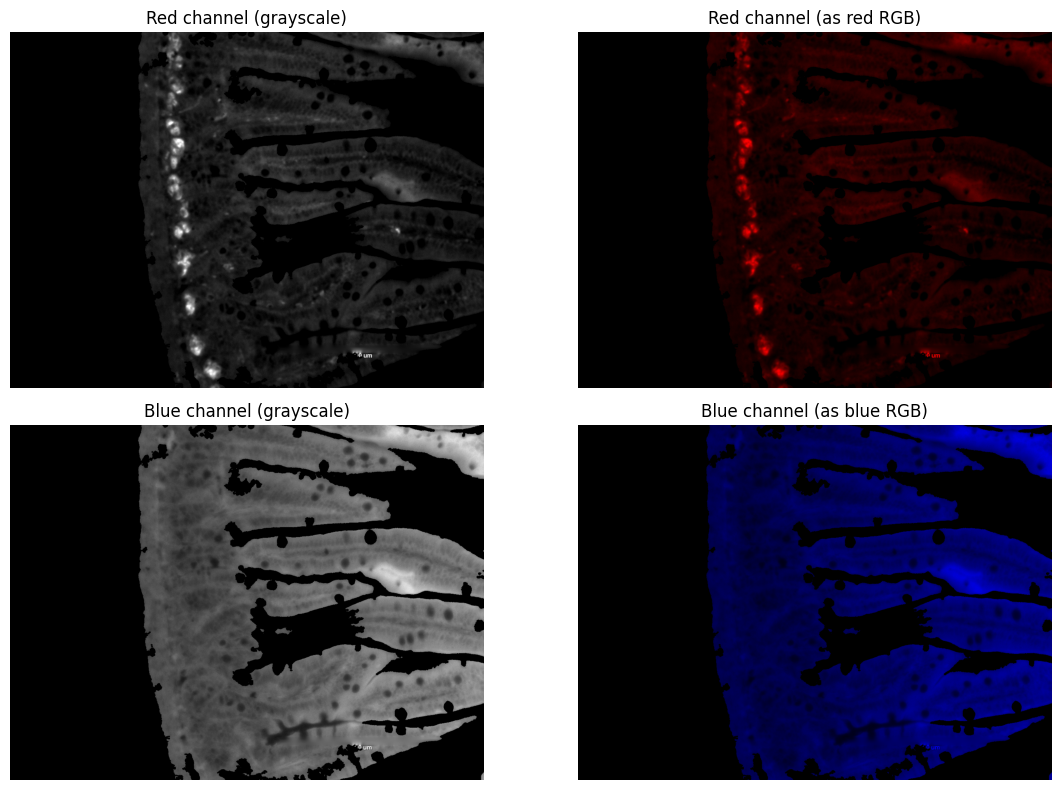

In [25]:
# extract channels (assuming img is HxWx3 in RGB order)
red_ch = img[..., 0]
blue_ch = img[..., 2]

# show channels: grayscale and as single-channel colored RGB
rgb_red = np.zeros_like(img)
rgb_red[..., 0] = red_ch
rgb_blue = np.zeros_like(img)
rgb_blue[..., 2] = blue_ch

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(red_ch, cmap="gray", vmin=0, vmax=255)
plt.title("Red channel (grayscale)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(rgb_red)
plt.title("Red channel (as red RGB)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(blue_ch, cmap="gray", vmin=0, vmax=255)
plt.title("Blue channel (grayscale)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(rgb_blue)
plt.title("Blue channel (as blue RGB)")
plt.axis("off")

plt.tight_layout()
plt.show()

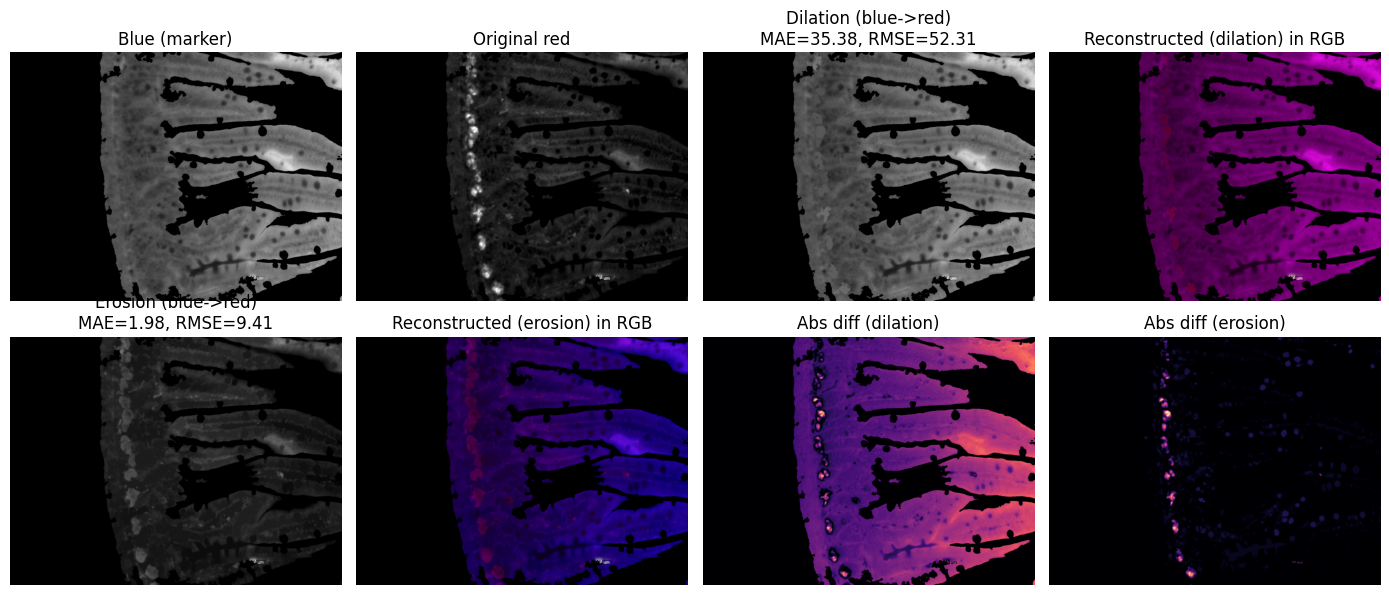

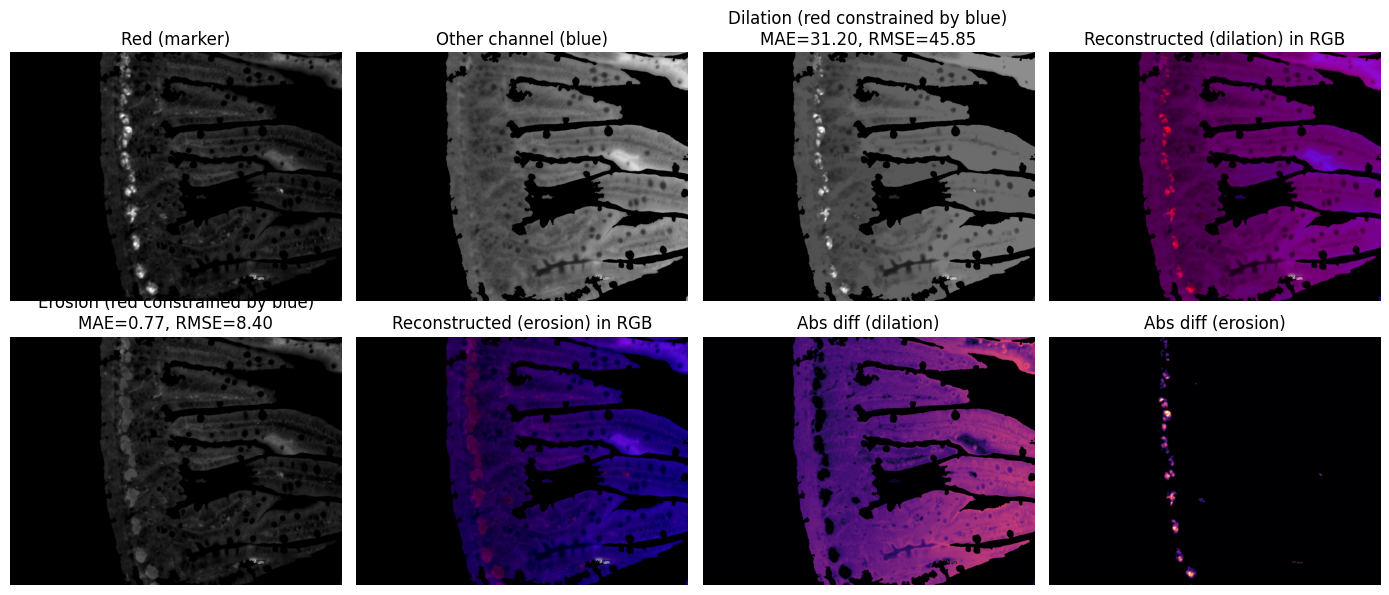

In [33]:
from skimage.morphology import reconstruction

# prepare both blue->red and red->blue reconstructions
disp = img[..., :3] if img.ndim == 3 and img.shape[-1] in (3, 4) else np.stack([img]*3, axis=-1)
marker_b = blue_ch.astype(np.float32)
other_b = red_ch.astype(np.float32)
mask_b_dilation = np.maximum(other_b, marker_b)   # for dilation: marker <= mask
mask_b_erosion  = np.minimum(other_b, marker_b)   # for erosion:  marker >= mask

marker_r = red_ch.astype(np.float32)
other_r = blue_ch.astype(np.float32)
mask_r_dilation = np.maximum(other_r, marker_r)
mask_r_erosion  = np.minimum(other_r, marker_r)

# morphological reconstructions
recon_d_blue = reconstruction(marker_b, mask_b_dilation, method="dilation")
recon_e_blue = reconstruction(marker_b, mask_b_erosion,  method="erosion")

recon_d_red  = reconstruction(marker_r, mask_r_dilation, method="dilation")
recon_e_red  = reconstruction(marker_r, mask_r_erosion,  method="erosion")

# convert back to uint8
recon_d_blue_u8 = np.clip(recon_d_blue, 0, 255).astype(np.uint8)
recon_e_blue_u8 = np.clip(recon_e_blue, 0, 255).astype(np.uint8)
recon_d_red_u8  = np.clip(recon_d_red,  0, 255).astype(np.uint8)
recon_e_red_u8  = np.clip(recon_e_red,  0, 255).astype(np.uint8)

# error metrics (compare all reconstructions to the original red channel)
def mae(a, b): return np.mean(np.abs(a.astype(np.int32) - b.astype(np.int32)))
def rmse(a, b): return np.sqrt(np.mean((a.astype(np.float32) - b.astype(np.float32))**2))

mae_db, rmse_db = mae(recon_d_blue_u8, red_ch), rmse(recon_d_blue_u8, red_ch)
mae_eb, rmse_eb = mae(recon_e_blue_u8, red_ch), rmse(recon_e_blue_u8, red_ch)
mae_dr, rmse_dr = mae(recon_d_red_u8,  red_ch), rmse(recon_d_red_u8,  red_ch)
mae_er, rmse_er = mae(recon_e_red_u8,  red_ch), rmse(recon_e_red_u8,  red_ch)

# RGB visualizations: insert reconstructed red into disp copy
vis_db = disp.copy(); vis_db[..., 0] = recon_d_blue_u8
vis_eb = disp.copy(); vis_eb[..., 0] = recon_e_blue_u8
vis_dr = disp.copy(); vis_dr[..., 0] = recon_d_red_u8
vis_er = disp.copy(); vis_er[..., 0] = recon_e_red_u8

# display blue-seed results
plt.figure(figsize=(14, 6))
plt.subplot(2, 4, 1); plt.imshow(blue_ch, cmap="gray", vmin=0, vmax=255); plt.title("Blue (marker)"); plt.axis("off")
plt.subplot(2, 4, 2); plt.imshow(red_ch, cmap="gray", vmin=0, vmax=255); plt.title("Original red"); plt.axis("off")
plt.subplot(2, 4, 3); plt.imshow(recon_d_blue_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Dilation (blue->red)\nMAE={mae_db:.2f}, RMSE={rmse_db:.2f}"); plt.axis("off")
plt.subplot(2, 4, 4); plt.imshow(vis_db); plt.title("Reconstructed (dilation) in RGB"); plt.axis("off")
plt.subplot(2, 4, 5); plt.imshow(recon_e_blue_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Erosion (blue->red)\nMAE={mae_eb:.2f}, RMSE={rmse_eb:.2f}"); plt.axis("off")
plt.subplot(2, 4, 6); plt.imshow(vis_eb); plt.title("Reconstructed (erosion) in RGB"); plt.axis("off")
plt.subplot(2, 4, 7); plt.imshow(np.abs(recon_d_blue_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (dilation)"); plt.axis("off")
plt.subplot(2, 4, 8); plt.imshow(np.abs(recon_e_blue_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (erosion)"); plt.axis("off")
plt.tight_layout()
plt.show()

# display red-seed results (marker = red)
plt.figure(figsize=(14, 6))
plt.subplot(2, 4, 1); plt.imshow(red_ch, cmap="gray", vmin=0, vmax=255); plt.title("Red (marker)"); plt.axis("off")
plt.subplot(2, 4, 2); plt.imshow(blue_ch, cmap="gray", vmin=0, vmax=255); plt.title("Other channel (blue)"); plt.axis("off")
plt.subplot(2, 4, 3); plt.imshow(recon_d_red_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Dilation (red constrained by blue)\nMAE={mae_dr:.2f}, RMSE={rmse_dr:.2f}"); plt.axis("off")
plt.subplot(2, 4, 4); plt.imshow(vis_dr); plt.title("Reconstructed (dilation) in RGB"); plt.axis("off")
plt.subplot(2, 4, 5); plt.imshow(recon_e_red_u8, cmap="gray", vmin=0, vmax=255)
plt.title(f"Erosion (red constrained by blue)\nMAE={mae_er:.2f}, RMSE={rmse_er:.2f}"); plt.axis("off")
plt.subplot(2, 4, 6); plt.imshow(vis_er); plt.title("Reconstructed (erosion) in RGB"); plt.axis("off")
plt.subplot(2, 4, 7); plt.imshow(np.abs(recon_d_red_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (dilation)"); plt.axis("off")
plt.subplot(2, 4, 8); plt.imshow(np.abs(recon_e_red_u8.astype(int) - red_ch.astype(int)), cmap="magma"); plt.title("Abs diff (erosion)"); plt.axis("off")
plt.tight_layout()
plt.show()


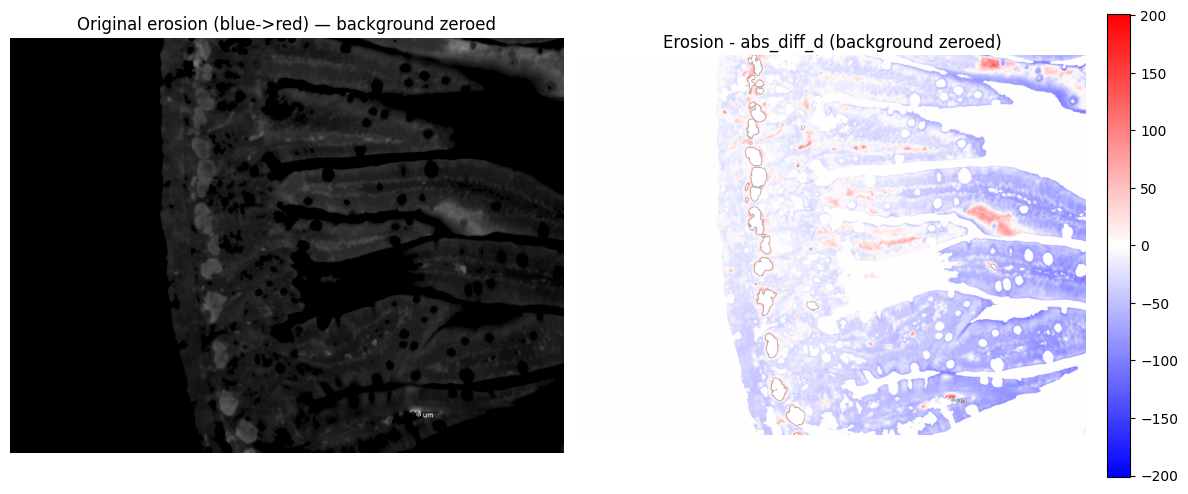

In [34]:
# apply background mask so masked-out pixels become zero everywhere
# (mask is boolean: True = foreground kept, False = background -> zero)
mask_bool = mask.astype(bool)

# masked version of original erosion (blue->red)
recon_e_masked = recon_e_blue_u8.astype(float).copy()
recon_e_masked[~mask_bool] = 0

# use existing diff_vis but set background (where mask is False) to 0 as requested
diff = recon_e_blue_u8.astype(np.int16) - np.rint(abs_diff_d).astype(np.int16)

# mask out locations where dilation == red (abs_diff_d == 0)
mask = (abs_diff_d != 0)

# prepare a visualization array with NaN where we want to hide values
diff_vis = np.full(diff.shape, np.nan, dtype=float)
diff_vis[mask] = diff[mask]

diff_vis_masked = diff_vis.copy()
diff_vis_masked[~mask_bool] = 0

# plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(recon_e_masked, cmap="gray", vmin=0, vmax=255)
plt.title("Original erosion (blue->red) — background zeroed")
plt.axis("off")

plt.subplot(1, 2, 2)
# symmetric color limits for diverging colormap (ignore NaNs)
if np.isnan(diff_vis_masked).all():
    clim2 = 1.0
else:
    clim2 = np.nanmax(np.abs(diff_vis_masked))
im = plt.imshow(diff_vis_masked, cmap="bwr", vmin=-clim2, vmax=clim2)
plt.title("Erosion - abs_diff_d (background zeroed)")
plt.axis("off")
plt.colorbar(im, fraction=0.045, pad=0.04)

plt.tight_layout()
plt.show()
